<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#User-functions" data-toc-modified-id="User-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>User functions</a></span></li><li><span><a href="#Single-run-tests" data-toc-modified-id="Single-run-tests-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Single run tests</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span><ul class="toc-item"><li><span><a href="#Layers-num" data-toc-modified-id="Layers-num-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Layers num</a></span></li><li><span><a href="#Neurons-number" data-toc-modified-id="Neurons-number-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Neurons number</a></span></li><li><span><a href="#Активационная-функция" data-toc-modified-id="Активационная-функция-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Активационная функция</a></span></li><li><span><a href="#Dropout" data-toc-modified-id="Dropout-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Dropout</a></span></li><li><span><a href="#Batch-Size" data-toc-modified-id="Batch-Size-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Batch Size</a></span></li></ul></li><li><span><a href="#Обучение-финальной-модели-и-валидация-на-тестовой-выборке" data-toc-modified-id="Обучение-финальной-модели-и-валидация-на-тестовой-выборке-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение финальной модели и валидация на тестовой выборке</a></span></li></ul></div>

In [13]:
# 1. Basic Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import itertools
import warnings
import time
from pprint import pprint
import seaborn as sns

from tensorflow import keras as keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import warnings

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

%matplotlib inline
warnings.filterwarnings('ignore')

#### Loading data

In [2]:
from keras.datasets import fashion_mnist

(train_images,train_labels),(test_images, test_labels)=fashion_mnist.load_data()

train_images = (train_images / 255) * 2 - 1
test_images = (test_images / 255) * 2 - 1

train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

print(train_images.shape) # (60000, 784)
print(test_images.shape)  # (10000, 784)

Using TensorFlow backend.


(60000, 784)
(10000, 784)


#### User functions

Для простоты подбора параметров введены несколько декорирующих функций
- show_pic - выводит картинку
- full_dense_classifier_compiler - компилирует модель с произвольным кол-вом слоев
- mlp_fit_valid - обучает и возвращает обученную модель
- mlp_predict - производит прогноз на тестовой выборке (c опцией переобучения на всей тренировочной выборке)
- plot_conf_matrix - рисует conf.matrix

In [42]:
def show_pic(pic_df, idx, grid=False, colorbar=False):
    shape = int(len(train_images[idx])**0.5)
    shape = (shape, shape)
    plt.grid(grid)
    plt.imshow((pic_df[idx,:].reshape(shape)+1)/2)
    if colorbar:
        plt.colorbar()
    plt.show()
      

def full_dense_classifier_compiler(layers_list, compile_params,  display_model=True):
    compile_params_keys = list(compile_params.keys())
    
    if len( set(compile_params_keys) - set(['optimizer', 'loss', 'metrics']) ) > 0:
        raise KeyError('incorrect compile params name')
    
    model = Sequential()
    
    for layer in layers_list:
        model.add(layer)
    
    optimizer = compile_params['optimizer']
    loss = compile_params['loss']
    metrics = compile_params['metrics']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    if display_model:
        model.summary()

    return model


def mlp_fit_valid(model, train_images,train_labels, n_classes, n_epochs=10, batch_size=32, 
                  validation_split=0.15, use_early_stopping=False, verbose_mode=0, show_chart=True):
    
    
    train_labels_cat = to_categorical(train_labels, n_classes)
    
    if use_early_stopping:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=0.15*n_epochs)
        callbacks = [es]
    else:
        callbacks = None
    
    start_time = time.time()
    history = model.fit(train_images, train_labels_cat, epochs=n_epochs, batch_size=batch_size, 
                        validation_split=validation_split, shuffle=True, verbose=verbose_mode,
                        callbacks=callbacks)
    
    if show_chart:
        fig = plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='valid')
        plt.legend()
        plt.show()
    
    best_idx = np.array(history.history['val_loss']).argmin()
    optimal_epoch_number = history.epoch[best_idx] + 1
    best_val_acc = history.history['val_accuracy'][best_idx]
    best_val_loss = history.history['val_loss'][best_idx]
    best_tr_acc = history.history['accuracy'][best_idx]
    
    
    print(f'optimal epoch number: {optimal_epoch_number}')
    print('params on optimal epoch:')
    print(f'accuracy on valid: {best_val_acc:.4f}, on train: {best_tr_acc:.4f}')
    print(f'best val loss: {best_val_loss}')
    print(f'refit finished in {(time.time()-start_time):1f} sec')
          
    return model
    
        
def plot_conf_matrix(y_true, y_pred, cmap=plt.cm.Blues,
                          show_cbar=False, font_size=11, font_style='normal', alpha=1,
                          linecolor='white', linewidths=0.1):

    cnf_matrix = confusion_matrix(y_true, y_pred)

    xticklabels = list(set(y_true))
    matrix = cnf_matrix[::-1]
    yticklabels = xticklabels[::-1]

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()

    annot_kws = {
        'fontsize': font_size,
        'fontstyle': font_style,
        'alpha': alpha
    }

    cbar_kws = {"orientation": "vertical",
                "shrink": 1,
                'extend': 'max',
                'extendfrac': 0.01,
                "drawedges": False,
                }

    ax.set_title('Confusion Matrix')

    sns.heatmap(matrix, square=True, ax=ax, cmap=cmap, annot=True, fmt='d',
                annot_kws=annot_kws, cbar=show_cbar, cbar_kws=cbar_kws, linecolor=linecolor,
                linewidths=linewidths, xticklabels=xticklabels, yticklabels=yticklabels)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    ax.set_ylim([0, len(matrix)])
    ax.set_xlabel('predicted class')
    ax.set_ylabel('true class')
    plt.show()
    
def mlp_predict(model, train_images, train_labels, test_images, test_labels, n_classes, 
                n_epochs=10, batch_size=32, refit_model_on_full_data=True, verbose_refit=0,
                show_metrics_on_test=True, show_conf_matrix=True):
    
    train_labels_cat = to_categorical(train_labels, n_classes)
    
    if refit_model_on_full_data:
        start_time = time.time()
        print('refit on full train (99%) dataset activated')
        model.fit(train_images, train_labels_cat, epochs=n_epochs, batch_size=batch_size, validation_split=0.01,
                 verbose=verbose_refit)
        print(f'refit succeed in {(time.time()-start_time):.1f} sec')
        print()
    
    start_time = time.time()
    predict = model.predict(test_images)
    print(f'predict generated in {(time.time()-start_time):.1f} sec')
    predict = np.argmax(predict, axis=1)
        
    if show_metrics_on_test:
        print(classification_report(test_labels, predict))
    
    if show_conf_matrix:
        plot_conf_matrix(test_labels, predict)
    
    return predict




#### Single run tests

Проверка работоспособности пользовательских функций

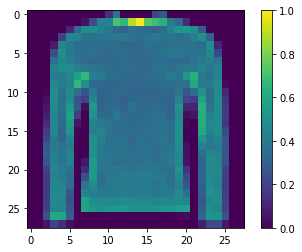

In [39]:
# 3.1. Вывод картинки

show_pic(train_images,37, colorbar=True)

In [43]:
# 3.2. Компиляция модели

layer_in =  Dense(64, activation='relu', input_shape=(784,))
layer2 = Dense(32, activation='sigmoid')
layer3 = Dense(32, activation='tanh')
layer_reg = Dropout(rate=0.2)
layer_out = Dense(10, activation='softmax')

comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': 'adam',
    'metrics': ['accuracy']
}

full_dense_classifier_compiler(layers_list=[layer_in, layer2, layer_reg, layer3, layer_out],
                              compile_params=comp_params)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 64)                50240     
_________________________________________________________________
dense_132 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_134 (Dense)            (None, 10)                330       
Total params: 53,706
Trainable params: 53,706
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 64)                50240     
_________________________________________________________________
dense_132 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_134 (Dense)            (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
Train on 51000 samples, validate on 9000 samples
Epoch 1/10
51000/51000 [==============================] - 4s 79us/sample - loss: 0.3088 - accuracy: 0.8904 - val_loss: 0.3561 - val_accuracy: 0.8763
Epoch 2/10
51000/51000 [=========================

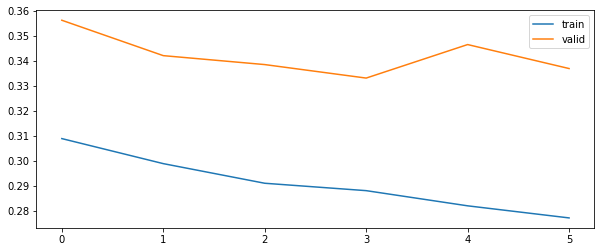

optimal epoch number: 4
params on optimal epoch:
accuracy on valid: 0.8820, on train: 0.8969
best val loss: 0.3330064791647924
refit finished in 22.547732 sec


In [45]:
# 3.3. Запуск модели с Early Stopping

model = full_dense_classifier_compiler(layers_list=[layer_in, layer2, layer_reg, layer_out],
                              compile_params=comp_params)


model = mlp_fit_valid(model, train_images,train_labels, n_classes=10, n_epochs=10, batch_size=32, 
                   validation_split=0.15, use_early_stopping=True, verbose_mode=1, show_chart=True)

Train on 51000 samples, validate on 9000 samples
Epoch 1/10
51000/51000 [==============================] - 4s 72us/sample - loss: 0.2696 - accuracy: 0.9036 - val_loss: 0.3382 - val_accuracy: 0.8828
Epoch 2/10
51000/51000 [==============================] - 4s 70us/sample - loss: 0.2647 - accuracy: 0.9026 - val_loss: 0.3429 - val_accuracy: 0.8828
Epoch 3/10
51000/51000 [==============================] - 4s 70us/sample - loss: 0.2563 - accuracy: 0.9065 - val_loss: 0.3451 - val_accuracy: 0.8822
Epoch 4/10
51000/51000 [==============================] - 4s 70us/sample - loss: 0.2530 - accuracy: 0.9079 - val_loss: 0.3355 - val_accuracy: 0.8870
Epoch 5/10
51000/51000 [==============================] - 4s 71us/sample - loss: 0.2493 - accuracy: 0.9097 - val_loss: 0.3446 - val_accuracy: 0.8834
Epoch 6/10
51000/51000 [==============================] - 4s 76us/sample - loss: 0.2475 - accuracy: 0.9102 - val_loss: 0.3480 - val_accuracy: 0.8853
Epoch 7/10
51000/51000 [==============================] -

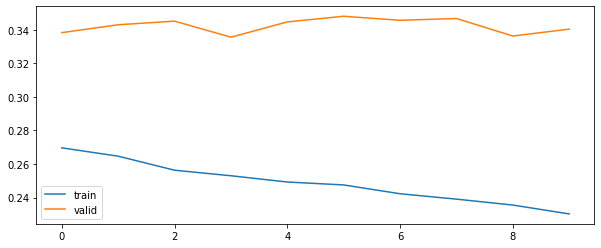

optimal epoch number: 4
params on optimal epoch:
accuracy on valid: 0.8870, on train: 0.9079
best val loss: 0.33551702566941577
refit finished in 37.277639 sec


In [47]:
# 3.3. Запуск модели без Early Stopping

model = mlp_fit_valid(model, train_images,train_labels, n_classes=10, n_epochs=10, batch_size=32, 
                 validation_split=0.15, use_early_stopping=False, verbose_mode=1, show_chart=True)

predict generated in 0.3 sec
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.82      0.78      0.80      1000
           3       0.88      0.89      0.89      1000
           4       0.81      0.81      0.81      1000
           5       0.98      0.93      0.95      1000
           6       0.73      0.67      0.70      1000
           7       0.91      0.96      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



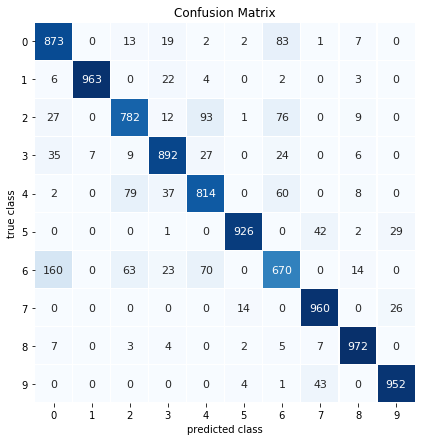

In [48]:
# 3.3. Генерация прогноза без переобучения

predict_single = mlp_predict(model, train_images, train_labels, test_images, test_labels, n_classes=10, 
                            n_epochs=4, batch_size=32, refit_model_on_full_data=False,
                            show_metrics_on_test=True, show_conf_matrix=True)

refit on full train (99%) dataset activated
refit succeed in 14.0 sec

predict generated in 0.2 sec
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.79      0.82      0.81      1000
           3       0.87      0.90      0.88      1000
           4       0.81      0.80      0.80      1000
           5       0.96      0.95      0.96      1000
           6       0.72      0.70      0.71      1000
           7       0.93      0.96      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



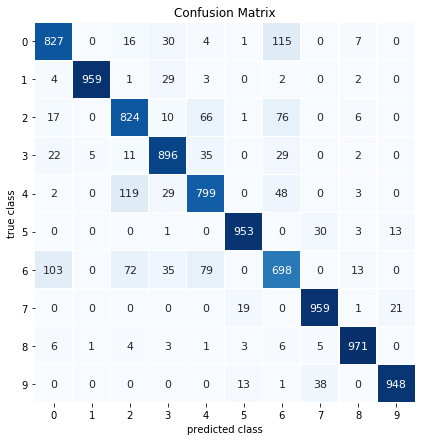

In [49]:
# 3.4. Генерация прогноза с переобучением на всей выборке

predict_single = mlp_predict(model, train_images, train_labels, test_images, test_labels, n_classes=10, 
                            n_epochs=4, batch_size=32, refit_model_on_full_data=True,
                            show_metrics_on_test=True, show_conf_matrix=True)

#### Подбор гиперпараметров

- я буду использовать early stopping callback с 15% долей

- поиск будет вестись с последовательным сужением пространства гиперпараметров
  - поиск оптимальной архитектуры (без учета Dropout), c использованием Relu и с небольшим числом нодов (32)
    - 1 слой
    - 2 слоя
    - 3 слоя
    - 4 слоя    
  - количество нодов
  - выбор оптимальной активационной функции
  - добавление dropout
  - выбор batch size

In [50]:
# 4.1. basic params
input_shape = (784,)
n_classes = 10
n_epochs = 40

comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': 'adam',
    'metrics': ['accuracy']
}


##### Layers num

1-layer
--------------------------------------------------------------------------------
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_433 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_434 (Dense)            (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
Epoch 00017: early stopping


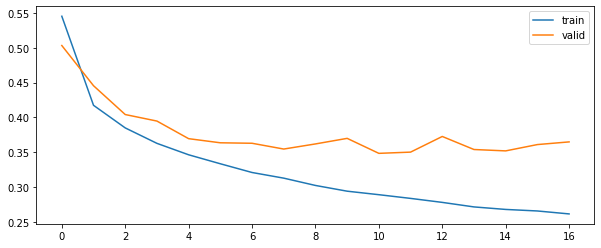

optimal epoch number: 11
params on optimal epoch:
accuracy on valid: 0.8765, on train: 0.8935
best val loss: 0.3482603352665901
refit finished in 45.195682 sec
********************************************************************************
2-layer
--------------------------------------------------------------------------------
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_435 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_436 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_437 (Dense)            (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________
Epoch 00016: early stopping


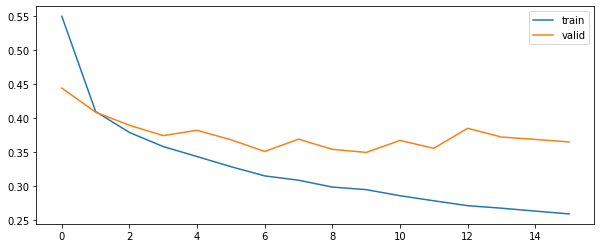

optimal epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8752, on train: 0.8905
best val loss: 0.34963023954629896
refit finished in 44.310653 sec
********************************************************************************
3-layer
--------------------------------------------------------------------------------
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_438 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_439 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_440 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_441 (Dense)            (None, 10)                330       
Total params: 27,562
Trainable params: 27,562
Non-tr

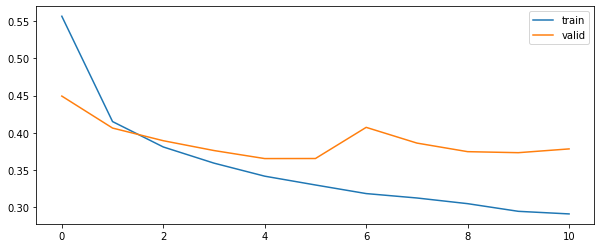

optimal epoch number: 5
params on optimal epoch:
accuracy on valid: 0.8658, on train: 0.8750
best val loss: 0.36536200300852456
refit finished in 32.175552 sec
********************************************************************************
4-layer
--------------------------------------------------------------------------------
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_442 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_443 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_444 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_445 (Dense)            (None, 32)                1056      
_____________________________________________________

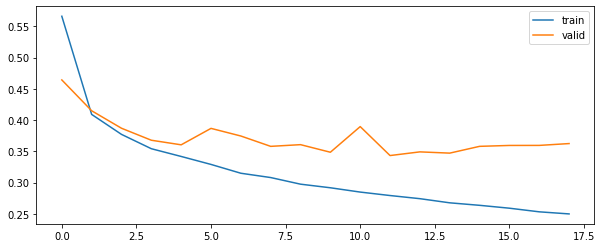

optimal epoch number: 12
params on optimal epoch:
accuracy on valid: 0.8788, on train: 0.8966
best val loss: 0.34330977366367976
refit finished in 55.141606 sec
********************************************************************************
5-layer
--------------------------------------------------------------------------------
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_447 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_448 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_449 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_450 (Dense)            (None, 32)                1056      
____________________________________________________

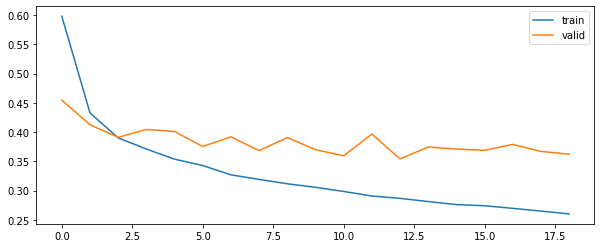

optimal epoch number: 13
params on optimal epoch:
accuracy on valid: 0.8722, on train: 0.8937
best val loss: 0.35423380935192106
refit finished in 61.133363 sec
********************************************************************************


In [77]:
# 4.1.1. Подбор количества слоев

layers_seq1 = [Dense(32, activation='relu', input_shape=input_shape), 
               Dense(10, activation='softmax')]

layers_seq2 = [Dense(32, activation='relu', input_shape=input_shape), 
               Dense(32, activation='relu'),               
               Dense(10, activation='softmax')]

layers_seq3 = [Dense(32, activation='relu', input_shape=input_shape), 
               Dense(32, activation='relu'),               
               Dense(32, activation='relu'),               
               Dense(10, activation='softmax')]

layers_seq4 = [Dense(32, activation='relu', input_shape=input_shape), 
               Dense(32, activation='relu'),               
               Dense(32, activation='relu'),               
               Dense(32, activation='relu'),               
               Dense(10, activation='softmax')]

layers_seq5 = [Dense(32, activation='relu', input_shape=input_shape), 
               Dense(32, activation='relu'),               
               Dense(32, activation='relu'),               
               Dense(32, activation='relu'),               
               Dense(32, activation='relu'),                              
               Dense(10, activation='softmax')]

labels = ['1-layer', '2-layer', '3-layer', '4-layer', '5-layer']

for seq, title in zip([layers_seq1, layers_seq2, layers_seq3, layers_seq4, layers_seq5], labels):
    
    print(title)
    print(80*'-')
    start = time.time()
    
    model = full_dense_classifier_compiler(layers_list=seq, compile_params=comp_params, display_model=True)
    
    model = mlp_fit_valid(model, train_images,train_labels, n_classes=n_classes, n_epochs=n_epochs, 
                          batch_size=32, validation_split=0.2, use_early_stopping=True, verbose_mode=0, 
                          show_chart=True)
    
    print(80*'*')
    

Наилучший вариант -4-слойный, хотя разница минимальная. На всякий случай оставим 3-слойный и отключим early callback

Выбранный вариант - 4-слойная архитектура

##### Neurons number

--------------------------------------------------------------------------------
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_528 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_529 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_530 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_531 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_532 (Dense)            (None, 10)                330       
Total params: 28,618
Trainable params: 28,618
Non-trainable params: 0
_________________________________________________________________
Epoch 00022: early stopping


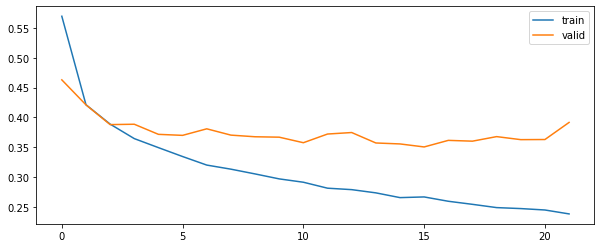

optimal epoch number: 16
params on optimal epoch:
accuracy on valid: 0.8779, on train: 0.9007
best val loss: 0.35050226813554763
refit finished in 68.930294 sec
********************************************************************************
--------------------------------------------------------------------------------
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_533 (Dense)            (None, 256)               200960    
_________________________________________________________________
dense_534 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_535 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_536 (Dense)            (None, 32)                2080      
____________________________________________________________

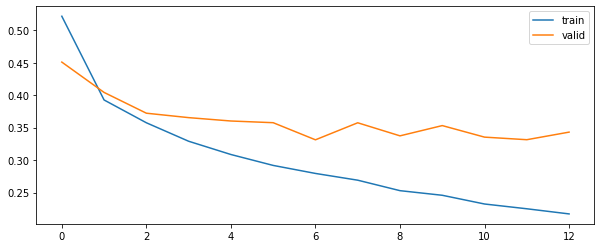

optimal epoch number: 7
params on optimal epoch:
accuracy on valid: 0.8820, on train: 0.8969
best val loss: 0.3312063126564026
refit finished in 40.674753 sec
********************************************************************************
--------------------------------------------------------------------------------
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_538 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_539 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_540 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_541 (Dense)            (None, 128)               16512     
______________________________________________________________

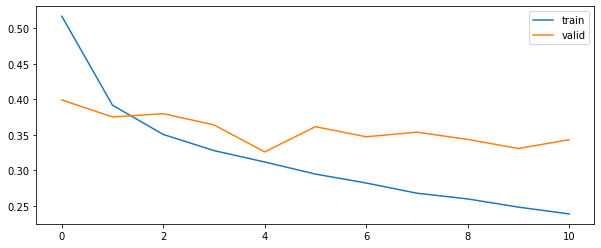

optimal epoch number: 5
params on optimal epoch:
accuracy on valid: 0.8843, on train: 0.8836
best val loss: 0.3259592667818069
refit finished in 34.473697 sec
********************************************************************************
--------------------------------------------------------------------------------
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_543 (Dense)            (None, 256)               200960    
_________________________________________________________________
dense_544 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_545 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_546 (Dense)            (None, 256)               65792     
______________________________________________________________

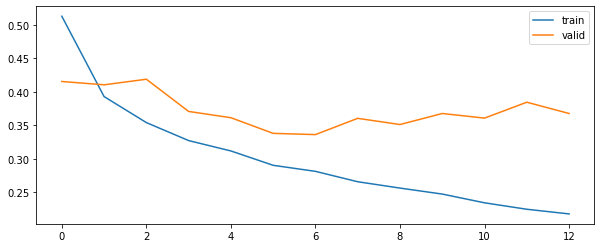

optimal epoch number: 7
params on optimal epoch:
accuracy on valid: 0.8826, on train: 0.8960
best val loss: 0.3362631607254346
refit finished in 40.772648 sec
********************************************************************************


In [81]:
# 4.2.1. Подбор количества нейронов

# для сравнения дополнительно будет добавлена однослойная - с большим количеством нейронов 
# и двух-слойная с большим и средним количеством нейронов


layers_seq1 = [Dense(32, activation='relu', input_shape=input_shape), 
               Dense(32, activation='relu'),               
               Dense(32, activation='relu'),               
               Dense(32, activation='relu'),
               Dense(10, activation='softmax')] # base case from prev.step

layers_seq2 = [Dense(256, activation='relu', input_shape=input_shape), 
               Dense(128, activation='relu'),
               Dense(64, activation='relu'),
               Dense(32, activation='relu'),               
               Dense(10, activation='softmax')]

layers_seq3 = [Dense(128, activation='relu', input_shape=input_shape), 
               Dense(128, activation='relu'),               
               Dense(128, activation='relu'),
               Dense(128, activation='relu'),
               Dense(10, activation='softmax')]

layers_seq4 = [Dense(256, activation='relu', input_shape=input_shape), 
               Dense(256, activation='relu'),               
               Dense(256, activation='relu'),
               Dense(256, activation='relu'),
               Dense(10, activation='softmax')]



for seq in [layers_seq1, layers_seq2, layers_seq3, layers_seq4]:
    print(80*'-')
    model = full_dense_classifier_compiler1(layers_list=seq, compile_params=comp_params, display_model=True)
    
    model = mlp_fit_valid(model, train_images,train_labels, n_classes=n_classes, n_epochs=n_epochs, 
                          batch_size=32, validation_split=0.2, use_early_stopping=True, verbose_mode=0, 
                          show_chart=True)
    
    print(80*'*')

--------------------------------------------------------------------------------
Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_587 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_588 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_589 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_590 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_591 (Dense)            (None, 10)                1290      
Total params: 151,306
Trainable params: 151,306
Non-trainable params: 0
_________________________________________________________________
Epoch 00016: early stopping


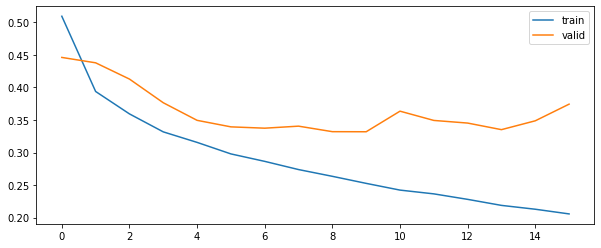

optimal epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8849, on train: 0.9058
best val loss: 0.33191082322597504
refit finished in 52.007350 sec
********************************************************************************
--------------------------------------------------------------------------------
Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_592 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_593 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_594 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_595 (Dense)            (None, 256)               131328    
___________________________________________________________

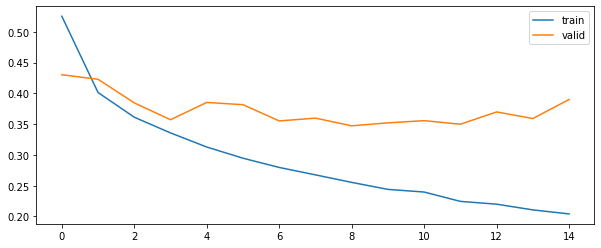

optimal epoch number: 9
params on optimal epoch:
accuracy on valid: 0.8845, on train: 0.9058
best val loss: 0.34732951591412226
refit finished in 50.240205 sec
********************************************************************************
--------------------------------------------------------------------------------
Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_597 (Dense)            (None, 1024)              803840    
_________________________________________________________________
dense_598 (Dense)            (None, 10)                10250     
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
_________________________________________________________________
Epoch 00011: early stopping


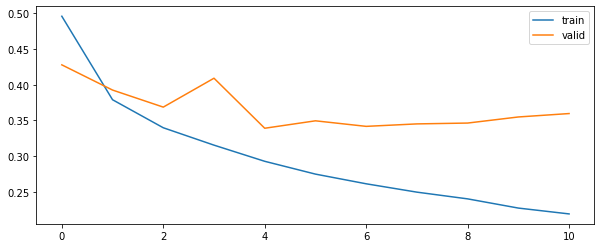

optimal epoch number: 5
params on optimal epoch:
accuracy on valid: 0.8796, on train: 0.8908
best val loss: 0.3391623345812162
refit finished in 31.914716 sec
********************************************************************************
--------------------------------------------------------------------------------
Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_599 (Dense)            (None, 1024)              803840    
_________________________________________________________________
dense_600 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_601 (Dense)            (None, 10)                5130      
Total params: 1,333,770
Trainable params: 1,333,770
Non-trainable params: 0
_________________________________________________________________
Epoch 00012: early stopping


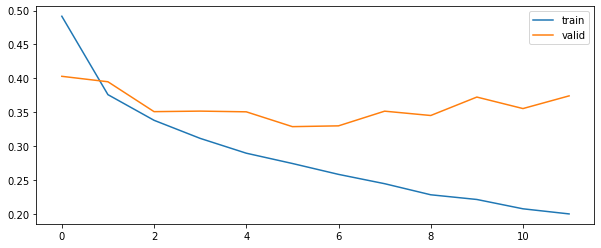

optimal epoch number: 6
params on optimal epoch:
accuracy on valid: 0.8815, on train: 0.8964
best val loss: 0.3288473789095879
refit finished in 37.419982 sec
********************************************************************************


In [85]:
# 4.2.1. Подбор количества нейронов с уменьшением слоев

# для сравнения дополнительно будет добавлена однослойная - с большим количеством нейронов 
# и двух-слойная с большим и средним количеством нейронов


layers_seq1 = [Dense(128, activation='relu', input_shape=input_shape), 
               Dense(128, activation='relu'),               
               Dense(128, activation='relu'),               
               Dense(128, activation='relu'),
               Dense(10, activation='softmax')] # base case from prev.step

layers_seq2 = [Dense(512, activation='relu', input_shape=input_shape), 
               Dense(512, activation='relu'),
               Dense(512, activation='relu'),
               Dense(256, activation='relu'),               
               Dense(10, activation='softmax')]

layers_seq3 = [Dense(1024, activation='relu', input_shape=input_shape), 
               Dense(10, activation='softmax')]

layers_seq4 = [Dense(1024, activation='relu', input_shape=input_shape), 
               Dense(512, activation='relu'),               
               Dense(10, activation='softmax')]


for seq in [layers_seq1, layers_seq2, layers_seq3, layers_seq4]:
    print(80*'-')
    model = full_dense_classifier_compiler(layers_list=seq, compile_params=comp_params, display_model=True)
    
    model = mlp_fit_valid(model, train_images,train_labels, n_classes=n_classes, n_epochs=n_epochs, 
                          batch_size=32, validation_split=0.2, use_early_stopping=True, verbose_mode=0, 
                          show_chart=True)
    
    print(80*'*')

По сути, возможно вследствие особенностей функции Relu или вследствие работы Full Dense, различие минимальны.
В качестве оптимального варианта выбран 2-хслойный вариант с большим количеством нейронов

##### Активационная функция

--------------------------------------------------------------------------------
Epoch 00014: early stopping


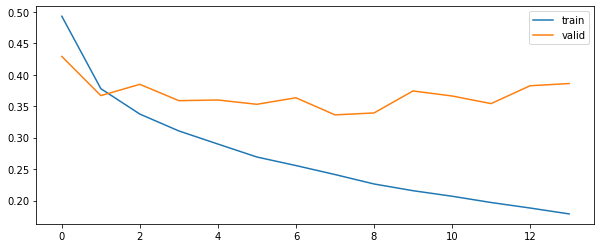

optimal epoch number: 8
params on optimal epoch:
accuracy on valid: 0.8845, on train: 0.9081
best val loss: 0.3361191749870777
refit finished in 45.136232 sec
********************************************************************************
--------------------------------------------------------------------------------
Epoch 00014: early stopping


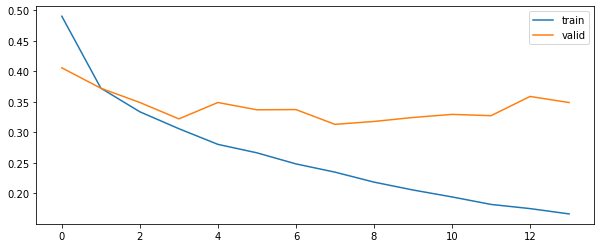

optimal epoch number: 8
params on optimal epoch:
accuracy on valid: 0.8867, on train: 0.9103
best val loss: 0.31302687313159305
refit finished in 45.261752 sec
********************************************************************************
--------------------------------------------------------------------------------
Epoch 00013: early stopping


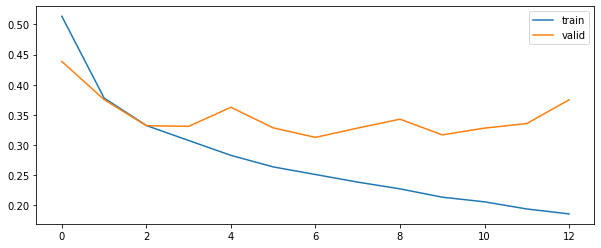

optimal epoch number: 7
params on optimal epoch:
accuracy on valid: 0.8874, on train: 0.9045
best val loss: 0.31272917026281355
refit finished in 38.741088 sec
********************************************************************************
--------------------------------------------------------------------------------
Epoch 00015: early stopping


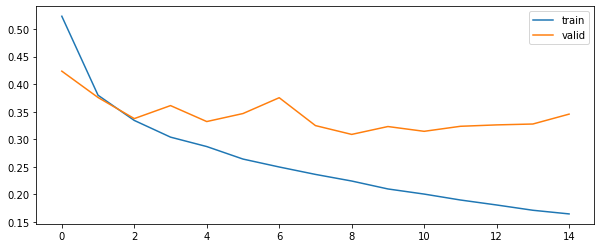

optimal epoch number: 9
params on optimal epoch:
accuracy on valid: 0.8924, on train: 0.9153
best val loss: 0.3087117076019446
refit finished in 45.460358 sec
********************************************************************************


In [86]:
layers_seq1 = [Dense(1024, activation='relu', input_shape=input_shape), 
               Dense(512, activation='relu'),               
               Dense(10, activation='softmax')]

layers_seq2 = [Dense(1024, activation='relu', input_shape=input_shape), 
               Dense(512, activation='sigmoid'),               
               Dense(10, activation='softmax')]

layers_seq3 = [Dense(1024, activation='sigmoid', input_shape=input_shape), 
               Dense(512, activation='relu'),               
               Dense(10, activation='softmax')]

layers_seq4 = [Dense(1024, activation='sigmoid', input_shape=input_shape), 
               Dense(512, activation='sigmoid'),               
               Dense(10, activation='softmax')]

for seq in [layers_seq1, layers_seq2, layers_seq3, layers_seq4]:
    print(80*'-')
    model = full_dense_classifier_compiler(layers_list=seq, compile_params=comp_params, display_model=False)
    
    model = mlp_fit_valid(model, train_images,train_labels, n_classes=n_classes, n_epochs=n_epochs, 
                          batch_size=32, validation_split=0.2, use_early_stopping=True, verbose_mode=0, 
                          show_chart=True)
    
    print(80*'*')

Наличие sigmoid - слегка улучшает loss

##### Dropout

--------------------------------------------------------------------------------
Epoch 00015: early stopping


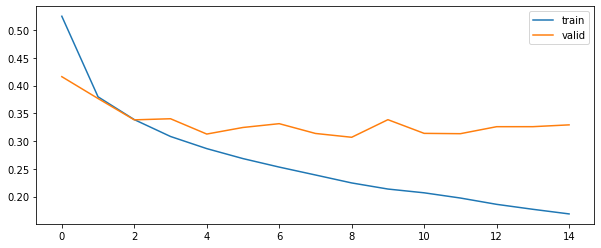

optimal epoch number: 9
params on optimal epoch:
accuracy on valid: 0.8911, on train: 0.9158
best val loss: 0.30695704941948254
refit finished in 47.480940 sec
********************************************************************************
--------------------------------------------------------------------------------
Epoch 00016: early stopping


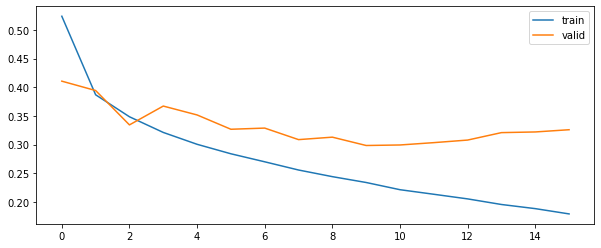

optimal epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8924, on train: 0.9103
best val loss: 0.2982836294869582
refit finished in 51.920521 sec
********************************************************************************
--------------------------------------------------------------------------------
Epoch 00015: early stopping


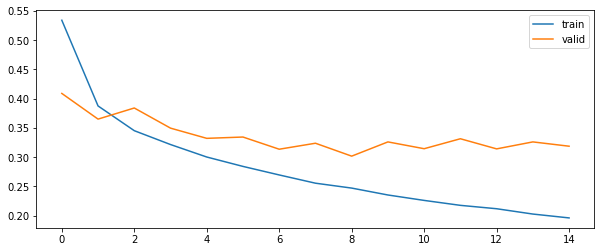

optimal epoch number: 9
params on optimal epoch:
accuracy on valid: 0.8913, on train: 0.9078
best val loss: 0.30172168715794884
refit finished in 48.815433 sec
********************************************************************************


In [90]:
# 4.4.1. Оптимальное расположение слоев
layers_seq1 = [Dense(1024, activation='sigmoid', input_shape=input_shape), 
               Dense(512, activation='sigmoid'),
               Dropout(0.1),
               Dense(10, activation='softmax')]

layers_seq2 = [Dense(1024, activation='sigmoid', input_shape=input_shape), 
               Dropout(0.1),
               Dense(512, activation='sigmoid'),               
               Dense(10, activation='softmax')]

layers_seq3 = [Dense(1024, activation='sigmoid', input_shape=input_shape), 
               Dropout(0.1),
               Dense(512, activation='sigmoid'),               
               Dropout(0.1),
               Dense(10, activation='softmax')]


for seq in [layers_seq1, layers_seq2, layers_seq3]:
    print(80*'-')
    model = full_dense_classifier_compiler(layers_list=seq, compile_params=comp_params, display_model=False)
    
    model = mlp_fit_valid(model, train_images,train_labels, n_classes=n_classes, n_epochs=n_epochs, 
                          batch_size=32, validation_split=0.2, use_early_stopping=True, verbose_mode=0, 
                          show_chart=True)
    
    print(80*'*')

--------------------------------------------------------------------------------
Epoch 00016: early stopping


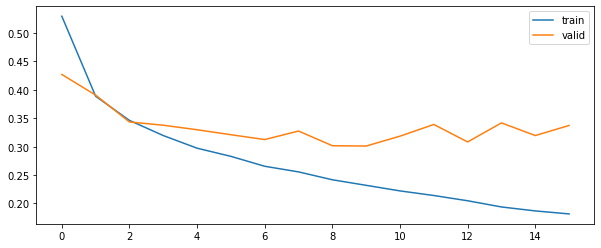

optimal epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8906, on train: 0.9129
best val loss: 0.3010993236303329
refit finished in 51.712032 sec
********************************************************************************
--------------------------------------------------------------------------------
Epoch 00024: early stopping


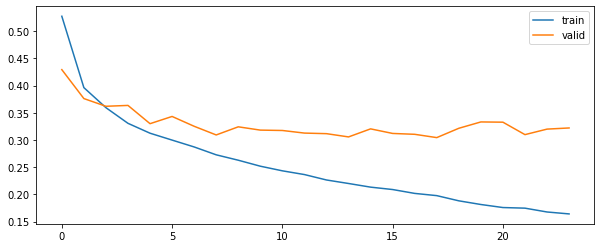

optimal epoch number: 18
params on optimal epoch:
accuracy on valid: 0.8967, on train: 0.9246
best val loss: 0.304342356522878
refit finished in 76.391956 sec
********************************************************************************
--------------------------------------------------------------------------------
Epoch 00026: early stopping


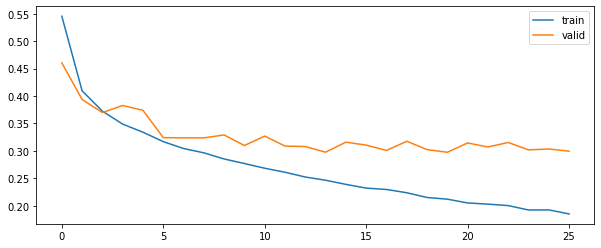

optimal epoch number: 20
params on optimal epoch:
accuracy on valid: 0.8992, on train: 0.9197
best val loss: 0.2974066424270471
refit finished in 83.133870 sec
********************************************************************************


In [91]:
# 4.4.2. Параметры dropout

layers_seq1 = [Dense(1024, activation='sigmoid', input_shape=input_shape), 
               Dropout(0.1),
               Dense(512, activation='sigmoid'),               
               Dense(10, activation='softmax')]

layers_seq2 = [Dense(1024, activation='sigmoid', input_shape=input_shape), 
               Dropout(0.2),
               Dense(512, activation='sigmoid'),               
               Dense(10, activation='softmax')]

layers_seq3 = [Dense(1024, activation='sigmoid', input_shape=input_shape), 
               Dropout(0.3),
               Dense(512, activation='sigmoid'),               
               Dense(10, activation='softmax')]


for seq in [layers_seq1, layers_seq2, layers_seq3]:
    print(80*'-')
    model = full_dense_classifier_compiler(layers_list=seq, compile_params=comp_params, display_model=False)
    
    model = mlp_fit_valid(model, train_images,train_labels, n_classes=n_classes, n_epochs=n_epochs, 
                          batch_size=32, validation_split=0.2, use_early_stopping=True, verbose_mode=0, 
                          show_chart=True)
    
    print(80*'*')



##### Batch Size

--------------------------------------------------------------------------------
batch size: 16
Epoch 00029: early stopping


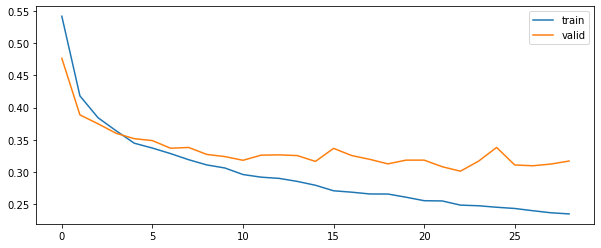

optimal epoch number: 23
params on optimal epoch:
accuracy on valid: 0.8936, on train: 0.9079
best val loss: 0.301030105954657
refit finished in 188.157009 sec
********************************************************************************
--------------------------------------------------------------------------------
batch size: 32
Epoch 00007: early stopping


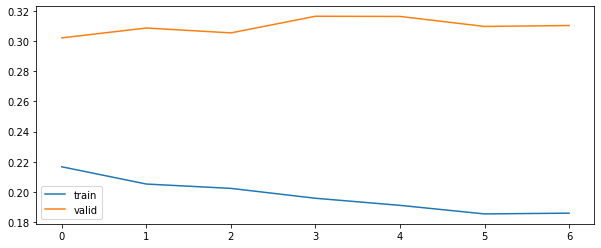

optimal epoch number: 1
params on optimal epoch:
accuracy on valid: 0.8936, on train: 0.9198
best val loss: 0.30201605635881423
refit finished in 23.754256 sec
********************************************************************************
--------------------------------------------------------------------------------
batch size: 64
Epoch 00008: early stopping


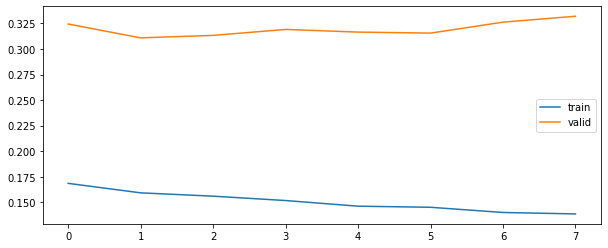

optimal epoch number: 2
params on optimal epoch:
accuracy on valid: 0.9001, on train: 0.9405
best val loss: 0.3108963357607524
refit finished in 15.240269 sec
********************************************************************************
--------------------------------------------------------------------------------
batch size: 256
Epoch 00007: early stopping


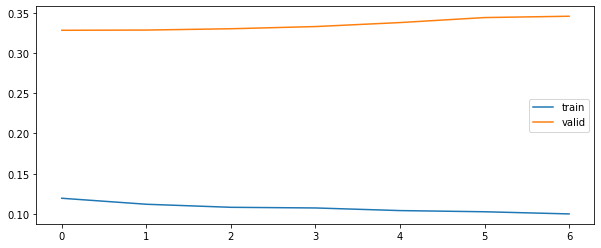

optimal epoch number: 1
params on optimal epoch:
accuracy on valid: 0.9015, on train: 0.9558
best val loss: 0.3282638399600983
refit finished in 5.401592 sec
********************************************************************************


In [93]:
layers_opt = [Dense(1024, activation='sigmoid', input_shape=input_shape), 
               Dropout(0.3),
               Dense(512, activation='sigmoid'),               
               Dense(10, activation='softmax')]

batch_sizes = [16, 32, 64, 256]

for bs in batch_sizes:
    print(80*'-')
    print(f'batch size: {bs}')
    model = full_dense_classifier_compiler(layers_list=layers_opt, compile_params=comp_params, display_model=False)
    
    model = mlp_fit_valid(model, train_images,train_labels, n_classes=n_classes, n_epochs=n_epochs, 
                          batch_size=bs, validation_split=0.2, use_early_stopping=True, verbose_mode=0, 
                          show_chart=True)
    
    print(80*'*')

Выводы по подбору параметров
- оптимальная архитектура: FC(1024, sigmoid) - DropOut(0.3) - FC(512, sigmoid) - FC(softmax)
- размер батча: 256
- при этом существенного прироста по метрике аккуратности достигнуто не было (в пределах 3-4%)
- с другой стороны было улучшено значение функции потерь ~10%

#### Обучение финальной модели и валидация на тестовой выборке

refit on full train (99%) dataset activated
Train on 59400 samples, validate on 600 samples
Epoch 1/5
59400/59400 [==============================] - 1s 17us/sample - loss: 0.0735 - accuracy: 0.9723 - val_loss: 0.3577 - val_accuracy: 0.9067
Epoch 2/5
59400/59400 [==============================] - 1s 13us/sample - loss: 0.0713 - accuracy: 0.9732 - val_loss: 0.3676 - val_accuracy: 0.9000
Epoch 3/5
59400/59400 [==============================] - 1s 12us/sample - loss: 0.0711 - accuracy: 0.9736 - val_loss: 0.3685 - val_accuracy: 0.8967
Epoch 4/5
59400/59400 [==============================] - 1s 12us/sample - loss: 0.0685 - accuracy: 0.9749 - val_loss: 0.3651 - val_accuracy: 0.9033
Epoch 5/5
59400/59400 [==============================] - 1s 12us/sample - loss: 0.0656 - accuracy: 0.9760 - val_loss: 0.3617 - val_accuracy: 0.9083
refit succeed in 3.9 sec

predict generated in 0.3 sec
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
    

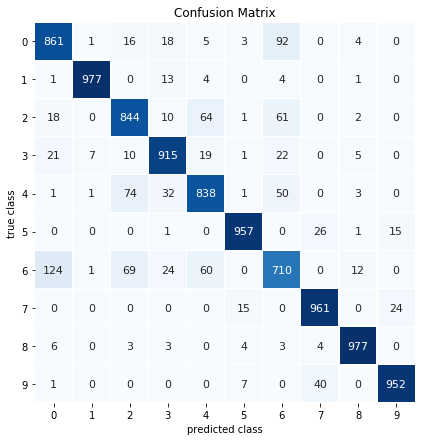

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [95]:
model = full_dense_classifier_compiler(layers_list=layers_opt, compile_params=comp_params, display_model=False)

mlp_predict(model, train_images, train_labels, test_images, test_labels, n_classes=n_classes, 
            n_epochs=5, batch_size=256, refit_model_on_full_data=True, verbose_refit=1,
            show_metrics_on_test=True, show_conf_matrix=True)